In [9]:
import os
import numpy as np
from keras_facenet import FaceNet
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to preprocess images for TensorFlow
def preprocess_image(image_path, target_size=(160, 160)):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array /= 255.0  # Normalize pixel values
    return img_array

# Load dataset and preprocess
def load_data(data_folder, target_size=(160, 160)):
    images = []
    labels = []
    label_map = {}
    current_label = 0

    for person_name in os.listdir(data_folder):
        person_folder = os.path.join(data_folder, person_name)
        if os.path.isdir(person_folder):
            label_map[current_label] = person_name
            for filename in os.listdir(person_folder):
                img_path = os.path.join(person_folder, filename)
                img = preprocess_image(img_path, target_size)
                images.append(img)
                labels.append(current_label)
            current_label += 1

    return np.array(images), np.array(labels), label_map

# data_folder = "../data/faces3"
data_folder = "../data/faces/train5_faces"
print("Loading dataset...")
images, labels, label_map = load_data(data_folder)
print(f"Loaded {len(images)} images across {len(label_map)} classes.")


Loading dataset...
Loaded 1059 images across 14 classes.


In [10]:
# Load the pre-trained FaceNet model
facenet = FaceNet()
base_model = facenet.model
# base_model.summary()


In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Freeze all layers in the base FaceNet model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(label_map), activation='softmax')(x)

# Define the new model
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# model.summary()


In [12]:
from sklearn.model_selection import train_test_split

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create data generators
train_datagen = ImageDataGenerator(rotation_range=10, zoom_range=0.2)
val_datagen = ImageDataGenerator()

# Fit data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Train the model
print("Training model...")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)



Training model...


/home/neyon/thomas_more/ai_frameworks/Face_Multiclassifier_Project/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 424ms/step - accuracy: 0.2589 - loss: 2.5508 - val_accuracy: 0.6840 - val_loss: 2.2127
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 329ms/step - accuracy: 0.6532 - loss: 2.0797 - val_accuracy: 0.7830 - val_loss: 1.6952
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 349ms/step - accuracy: 0.7804 - loss: 1.5344 - val_accuracy: 0.8160 - val_loss: 1.2634
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 338ms/step - accuracy: 0.8142 - loss: 1.1566 - val_accuracy: 0.8443 - val_loss: 0.9899
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 304ms/step - accuracy: 0.8422 - loss: 0.9119 - val_accuracy: 0.8396 - val_loss: 0.8269
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 306ms/step - accuracy: 0.8834 - loss: 0.7227 - val_accuracy: 0.8585 - val_loss: 0.7310
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 298ms/step - accuracy: 0.8837 - loss: 0.6068 - val_accuracy: 0.8632 - val_loss: 0.6829
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 303ms/step - accuracy: 0.8728 - loss: 0.5982 - val_accuracy: 0

In [13]:
# Save the trained model
model.save("../models/facenet_transfer_learning.keras")
print("Model saved.")


Model saved.


In [14]:
# from tensorflow.keras.models import load_model

# # Load the saved model
# model_path = "../models/facenet_transfer_learning.keras"
# loaded_model = load_model(model_path)

In [ ]:
# Load and preprocess test data
def load_test_data(test_folder, target_size=(160, 160)):
    test_images = []
    filenames = []
    for filename in sorted(os.listdir(test_folder)):
        img_path = os.path.join(test_folder, filename)
        img = preprocess_image(img_path, target_size)
        test_images.append(img)
        filenames.append(filename)
    return np.array(test_images), filenames

# test_folder = "../data/faces4_test"
test_folder = "../data/faces/test5_faces"
test_images, test_filenames = load_test_data(test_folder)

# Make predictions
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Reverse the label map (keys become values and vice versa)
label_map_reverse = {int(k): v for k, v in label_map.items()}  # Ensure keys are integers
predicted_names = [label_map_reverse[int(label)] for label in predicted_labels]

# Print the results
print(f"Predicted Names: {predicted_names}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step
Predicted Names: ['senne', 'senne', 'youssef', 'konrad', 'seppe', 'alper', 'senne', 'daiane', 'raul', 'raul', 'senne', 'bart', 'konrad', 'seppe', 'florian', 'alper', 'daiane', 'raul', 'youssef', 'akif', 'florian', 'akif', 'konrad', 'bart', 'akif', 'alper', 'seppe', 'konrad', 'senne', 'michiel', 'matthias', 'nelli', 'senne', 'youssef', 'matthias', 'akif', 'bart', 'alper', 'akif', 'raul', 'youssef', 'daiane', 'senne', 'senne', 'akif', 'seppe', 'michiel', 'raul', 'youssef', 'seppe', 'nelli', 'seppe', 'matthias', 'daiane', 'alper', 'raul', 'daiane', 'youssef', 'seppe', 'alper', 'alper', 'lasse', 'michiel', 'lasse', 'lasse', 'raul', 'florian', 'matthias', 'bart', 'senne', 'lasse', 'senne', 'youssef', 'seppe', 'konrad', 'lasse', 'michiel', 'konrad', 'nelli', 'florian', 'senne', 'nelli', 'seppe', 'michiel', 'raul', 'alper', 'konrad', 'youssef', 'akif', 'florian', 'matthias', 'matthias', 'matthias', 'florian', 'youssef', 'matthias', 'youssef', 'alper', 'm

In [21]:
import os
import pandas as pd

# Create submission file with grouped predictions and include missing images
def create_submission(filenames, predictions, output_path, image_folder):
    # Extract base filenames (e.g., "0037" from "0037_face_0")
    base_filenames = [filename.split('_face')[0] for filename in filenames]

    # Group predictions by base filename
    grouped_results = {}
    for base, prediction in zip(base_filenames, predictions):
        if base not in grouped_results:
            grouped_results[base] = []
        grouped_results[base].append(prediction)

    # Ensure all filenames in the image folder are included
    all_filenames = sorted(
        [os.path.splitext(filename)[0] for filename in os.listdir(image_folder) if filename.endswith('.jpg')]
    )

    # Prepare submission data
    submission_data = []
    for filename in all_filenames:
        if filename in grouped_results:
            label_name = ";".join(grouped_results[filename])
        else:
            label_name = "nothing"  # Add "nothing" for missing images
        submission_data.append({"image": filename, "label_name": label_name})

    # Save to CSV
    submission_df = pd.DataFrame(submission_data)
    submission_df.to_csv(output_path, index=False)
    print(f"Submission saved to {output_path}")

# Example usage
image_folder = "../data/images/test_images/cleaned_images"
output_path = "../submission.csv"
create_submission(test_filenames, predicted_names, output_path, image_folder)


Submission saved to ../submission.csv


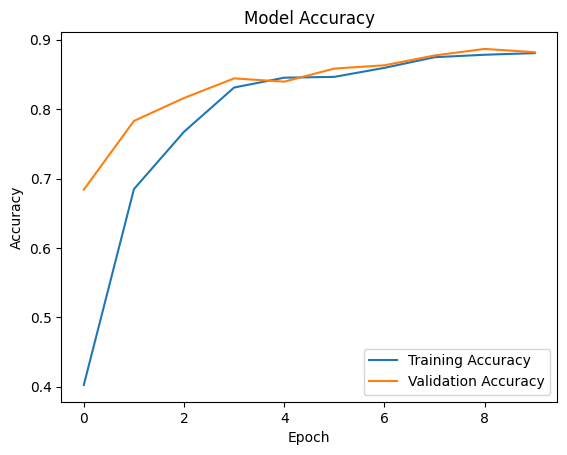

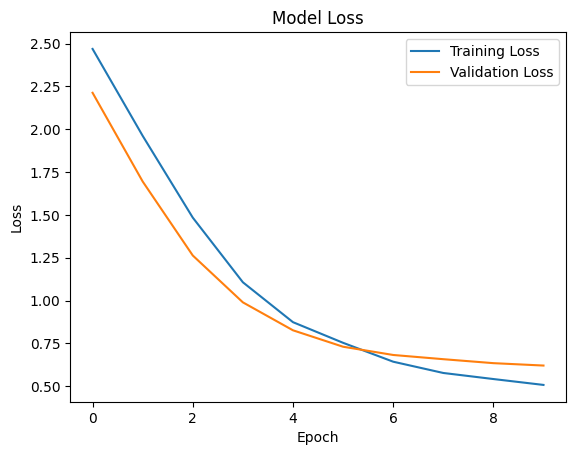

In [19]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
